<a href="https://colab.research.google.com/github/daviddralle/cannabit/blob/main/cannabit_gq_phil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and pull data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import seaborn as sns
from shapely.geometry import Polygon
from scipy.optimize import curve_fit
import geopandas as gp
import glob
import matplotlib
import pickle
import urllib3
import datetime
import time
from scipy.integrate import odeint
from scipy.interpolate import interp1d as interp1d
import scipy
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'

!git clone https://github.com/daviddralle/cannabit

Cloning into 'cannabit'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29 (delta 7), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 13.79 MiB | 9.91 MiB/s, done.
Resolving deltas: 100% (7/7), done.


# Read and format data

In [2]:
df = pd.read_csv('./cannabit/level4e.csv',index_col=0,parse_dates=True)
df = df[['dryRunoff_mmDay^-1']]
df.columns = ['runoff']
df.to_csv('./dry_discharge.csv')

!mkdir cannabit_data
!cp ./cannabit/level4e.csv /content/cannabit_data
!cp ./dry_discharge.csv /content/cannabit_data
!cp /content/cannabit/20240802_modeled_use_flow_landscape_coverage.csv /content/cannabit_data

# Define functions sensitivity function and binning

In [3]:
def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%site)
    try:
      geoms = [item for item in list(basin.geometry[0])]
      idx = np.argmax([item.area for item in geoms])
      basin.geometry = [geoms[idx]]
      print('Found multipolygon - fixing')
    except:
      basin.geometry = basin.geometry
    area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1000**2
    df = 2.44657555e12*df[['q']]/area_mm2
    df.q = df.q.astype(float, errors='ignore')
    df.columns = [site]
    return df, basin

# Sensitivity function [see Kirchner, 2009] doi:10.1029/2008WR006912
def gQ(q,p):
    if np.size(np.array(q)) == 1: return np.exp(np.sum([p[i]*np.log(q)**(len(p)-i-1) for i in range(len(p))]))
    return [np.exp(np.sum([p[i]*np.log(qq)**(len(p)-i-1) for i in range(len(p))])) for qq in np.array(q)]

# Bin dq/dt data
def KirchnerBinning(df, min_per_bin = 10, loud=False, binsizefrac=0.01):
    df = df.sort_values('q',ascending=False)
    logQ = np.array(np.log(df.q))
    logRange = np.max(logQ) - np.min(logQ)
    minBinSize = logRange*binsizefrac
    binBoundaries = [0]
    for i in range(1,len(df)):
        if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize:
            if loud: print('Bin too small')
            continue

        if abs(i-binBoundaries[-1]) < min_per_bin:
            if loud: print('Not enough data points')
            continue

        curr = df.dq[binBoundaries[-1]:i]
        if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2:
            if loud: print('Bin too heterogeneous')
            continue

        binBoundaries.append(i)
    return binBoundaries

# Read and format flow data

In [4]:
# basin name mapper
gageNumsToNames = {'11475560':'Elder Creek','00000000':'Dry Creek'}


# Grab Elder data
gagelist = ['11475560']
startyear = '1950'
endyear = '2019'
startdate = startyear + '-01-01'
enddate = endyear + '-12-31'
basins = []
dfs = []
for gage in gagelist:
  df, basin = getFlow(gage,startdate, enddate)
  dfs.append(df)
  basins.append(basin.geometry[0])

# create dataframe of Dry and Elder flows
flow = pd.concat(dfs,axis=1)
dry = pd.read_csv('./dry_discharge.csv',index_col=0,parse_dates=True)
dry = dry.resample('D').mean()
dry.columns = ['00000000']
gagelist.append('00000000')
flow = pd.concat([flow,dry],axis=1)
flow = flow.loc[np.isfinite(flow['00000000'])]
flow = flow.loc[startdate:enddate]

# Get sensitivity function via recession analysis

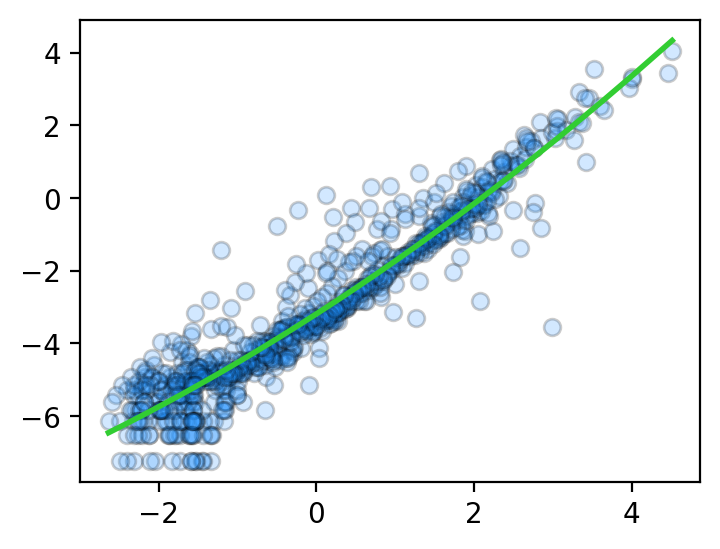

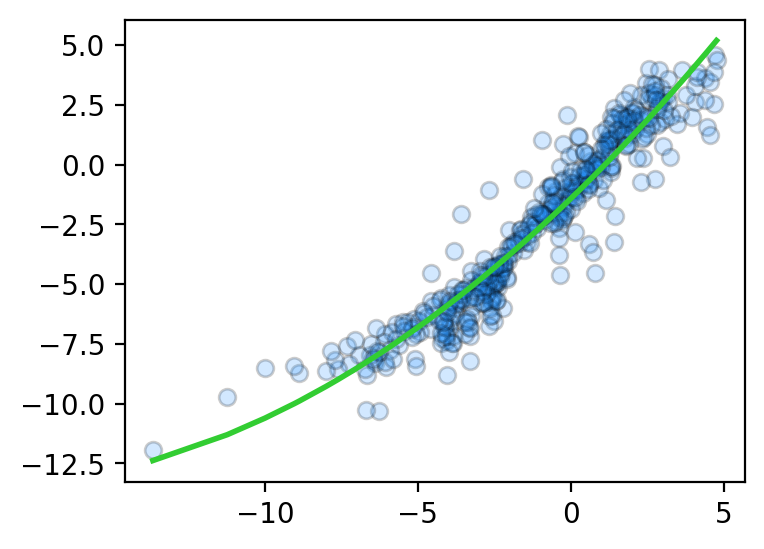

In [5]:
ps = {}
ecdfs = {}
whichmonths = [4,5]
for gage in flow.columns:
  # get typical flow values distribution for dry season start months
  ecdf = ECDF(flow.loc[flow.index.month.isin(whichmonths)][gage].values)
  ecdfs[gage] = ecdf
  tempdf = flow[[gage]]
  tempdf['year'] = tempdf.index.year
  tempdf['runoff'] = flow[gage]
  QS = []
  DQS = []
  # get dQ/dt
  for g in tempdf.groupby('year'):
    temp = g[1]
    date_q0 = temp.index.values[temp.runoff.argmax()]
    date_end = temp.index.values[-1]
    q0 = temp.runoff.max()
    qs = temp.runoff.loc[date_q0:].values
    dqs = np.gradient(qs)
    idx = (dqs<0)&(qs>0)
    qs = qs[idx]
    dqs = dqs[idx]
    QS = QS + list(qs)
    DQS = DQS + list(dqs)

  # perform recession analysis and get coefficients for gQ
  QS = np.array(QS)
  DQS = np.array(DQS)
  p = np.polyfit(x=np.log(QS), y=np.log(-DQS), deg=2)
  f,ax = plt.subplots(figsize=(4,3))
  x = np.log(QS)
  ax.scatter(np.log(QS),np.log(-DQS),ec='k',c='dodgerblue',alpha=0.2)
  x = np.sort(x)
  ax.plot(x, p[2] + p[1]*x + p[0]*x**2,lw=2,c='limegreen')
  p[1] = p[1] - 1
  ps[gage] = p

# Load modeled irrigation data

In [8]:
path = '/content/cannabit_data/20240802_modeled_use_flow_landscape_coverage.csv'
irrigation_data = pd.read_csv(path,index_col=0)
cols = irrigation_data.columns
cols = [col.replace('monhtyly','monthly') for col in cols]
cols = [col.replace('quantile','farm_use_percentile') for col in cols]
irrigation_data.columns = cols

# Iterate through all scenarios and solve for natural vs. impaired recessions

In [10]:
months = irrigation_data.month.values
years = irrigation_data.year.values
dates = pd.to_datetime([str(years[i]) + '-' + str(months[i]) for i in range(len(months))])
irrigation_data['datetime'] = dates
use_percentiles = [0.25, 0.5 , 0.75, 0.9 , 0.95]
covers = [0.01, 0.05, 0.1,0.25, 0.5, 1.0,2.5, 5.0, 7.5, 10.0]
mapper = {'Dry Creek':'Dry Creek', 'Elder':'Elder Creek'}
irrigation_data['catchment'] = irrigation_data.creek.map(mapper)
Q0s = [0.1, 0.5, 1.0,2.0, 3.0, 5.0, 7.0, 9.0, 10.0]

dfs = []
for u in use_percentiles:
  for c in covers:
    for g in ['00000000','11475560']:
      for q0 in Q0s:
        for source in ['surface','groundwater']:
          p = ps[g]
          name = gageNumsToNames[g]
          tempdf = irrigation_data.loc[irrigation_data.farm_use_percentile==u].copy()
          tempdf = tempdf.loc[tempdf.catchment==name]
          tempdf['use'] = tempdf.modeled_use_mm_day * c/100.0
          tempdf = tempdf[['use','datetime']]
          tempdf = tempdf.set_index('datetime').sort_index()

          dates = pd.date_range('2016-05','2016-10',freq='D')
          tempdf = tempdf.reindex(dates).interpolate()


          tempdf = tempdf.loc[tempdf.index.month.isin([5,6,7,8,9])]
          tempdf = tempdf.loc[tempdf.index.year==tempdf.index.year.unique()[0]].copy()

          # integrate to get natural and impaired flows
          t = np.linspace(0,len(tempdf),len(tempdf))
          forcing = interp1d(t,tempdf.use.values,fill_value="extrapolate")

          def fun(time,q):
            return -gQ(q,p)*q
          sol = solve_ivp(fun, [0, t[-1]], [q0], rtol = 1e-5)
          sol_int = interp1d(sol.t,sol.y[0],fill_value=0,bounds_error=False)
          natQ = sol_int(t)

          def fun(time,q):
            return -gQ(q,p)*(q + forcing(time))

          if source=='groundwater':
            sol = solve_ivp(fun, [0, t[-1]], [q0], rtol = 1e-5)
            sol_int = interp1d(sol.t,sol.y[0],fill_value=0,bounds_error=False)
            impQ = sol_int(t)
          else:
            impQ = natQ - tempdf.use.values
            impQ[impQ<0] = 0

          tempdf['impQ'] = impQ
          tempdf['natQ'] = natQ
          tempdf['source'] = source
          tempdf['q0'] = q0
          tempdf['q0_percentile'] = ecdfs[g](q0)*100
          tempdf['c'] = c
          tempdf['g'] = g
          tempdf['u'] = u
          dfs.append(tempdf.copy())


# Save simulation data

In [ ]:
data = pd.concat(dfs,axis=0)
path = '/content/sims_data.csv'
data.to_csv(path)

# Plot dry season start months CDF of flows

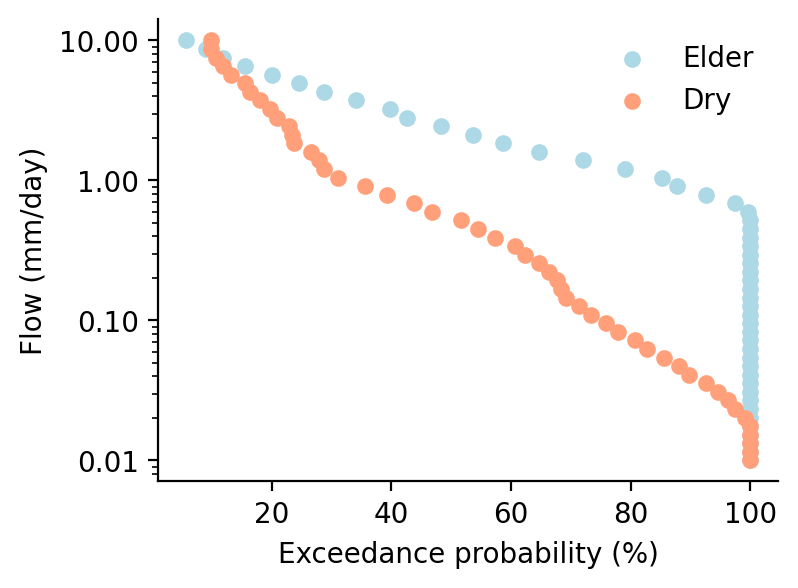

In [11]:
f,ax = plt.subplots(figsize=(4,3))
ecdf = ecdfs['11475560']
x = np.logspace(-2,1)
y = ecdf(x)
ax.scatter(100*(1-y),x,label='Elder',s=25,ec='lightblue',fc='lightblue')
# plt.yscale('log')

ecdf = ecdfs['00000000']
x = np.logspace(-2,1)
y = ecdf(x)
ax.scatter(100*(1-y),x,label='Dry',s=25,ec='lightsalmon',fc='lightsalmon')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylabel('Flow (mm/day)')
ax.set_xlabel('Exceedance probability (%)')

sns.despine()
ax.legend(framealpha=0)
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
